In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

import torch
import torchsde
from torch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM
from fab.target_distributions import gmm

from src.energies.base_prior import Prior, MeanFreePrior

from src.models.components.clipper import Clipper

from torch.func import hessian
from math import sqrt
from src.utils.data_utils import remove_mean
from math import sqrt, log

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
dimensionality = 2
temperature = 3.0
annealed_temperature = 1.0
inverse_temperature = temperature / annealed_temperature # beta in the paper


target = GMM(dimensionality=dimensionality,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True,
             temperature=temperature
             )

target_temp1 = GMM(dimensionality=dimensionality,
                   n_mixes=40,
                   loc_scaling= 40,
                   log_var_scaling=1.0,
                   device=device,
                   should_unnormalize=False,
                   temperature=1.0
                   )


samples = {}
energies = {}
test_samples = target_temp1.sample_test_set(1000)
samples["Test"] = test_samples.detach()

## Functions

### Utils

In [5]:
class VPSchedule():
    def __init__(self, beta_min, beta_max):
        self.beta_min = beta_min
        self.beta_max = beta_max

    def beta(self, t):
        # beta = -2 * d/dt log_alpha
        return  self.beta_min + (self.beta_max - self.beta_min) * t

    def log_mean_coeff(self, t): #log_alpha
        return -0.25 * t**2 * (self.beta_max - self.beta_min) - 0.5 * t * self.beta_min
    
    # ddt log_mean_coeff = -0.5 * t * (beta_max - beta_min) - 0.5 * beta_min

    def h(self, t): #variance
        return (1.0 - torch.exp(2.0 * self.log_mean_coeff(t)))
    
    def log_mean(self, t):
        return torch.exp(self.log_mean_coeff(t))

In [6]:
def true_Ut(target, x, t, noise_schedule, ve=True):
    h_t = noise_schedule.h(t).to(device)

    mean_coeff = None
    if not ve:
        mean_coeff = noise_schedule.log_mean(t).to(device)
    target.gmm.convolve(h_t * (target.data_normalization_factor**2), t, var_exploding=ve, mean_coeff=mean_coeff)
    energy = target(x)
    target.gmm.reset()
    return energy

In [7]:
def true_nabla_Ut(target, x, t, noise_schedule, ve=True):
    nabla_Ut = torch.func.jacrev(true_Ut, argnums=1)(target, x, t, noise_schedule, ve)
    return nabla_Ut

In [8]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=1, scramble=False)

def sample_cat(bs, next_u, logits):
    # u, next_u = sample_uniform(bs, next_u)
    u = sampler.random(bs).squeeze()
    bins = torch.cumsum(torch.softmax(logits, dim=-1), dim=-1)
    ids = np.digitize(u, bins.cpu())
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    return ids, next_u


def sample_cat_sys(bs, logits):
    u = torch.rand(size=(1,))
    u = (u + 1/bs*torch.arange(bs)) % 1
    bins = torch.cumsum(torch.softmax(logits, dim=-1), dim=-1)
    ids = np.digitize(u, bins.cpu())
    # print number of unique ids
    # ids = torch.tensor(ids, dtype=torch.long).to(device)
    # print(len(torch.unique(ids)))
    return ids, None

### SDEs

In [26]:
class VEReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, noise_schedule):
        super().__init__()
        self.noise_schedule = noise_schedule

    def f(self, t, x, resampling_interval=None, inverse_temperature=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)

            nabla_Ut = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(target, x, t, self.noise_schedule)

            drift_X = inverse_temperature * nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None:
                return  drift_X, drift_A
            
            drift_A = - 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
                             * (inverse_temperature-1) * inverse_temperature)
                             
            # drift_A = 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
            #                  * (inverse_temperature-1) * inverse_temperature)

        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g
    
    def dlogq_dt(self, t, x, dx, dt):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)
        nabla_logq = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(target, x, t, self.noise_schedule)
        return (nabla_logq * dx).sum(-1) - 0.5 * (self.g(t, x)[:, None] * nabla_logq).pow(2).sum(-1) * dt

In [10]:
class VPReverse_coupled(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, vp_scheduler):
        super().__init__()
        self.vp_scheduler = vp_scheduler

    def f(self, t, x, resampling_interval=None, inverse_temperature=1.0):
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)

        with torch.enable_grad():
            x.requires_grad_(True)
            t.requires_grad_(True)

            dlog_alphadt = - 0.5 * self.vp_scheduler.beta(t)
            nabla_Ut = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(target, x, t, self.vp_scheduler, ve=False)
            drift_X = - dlog_alphadt.unsqueeze(-1) * x + inverse_temperature * nabla_Ut * self.g(t, x).pow(2).unsqueeze(-1)

            if nabla_Ut.isnan().any():
                print("nabla_Ut is nan at time ", t[0])
                return
            
            drift_A = torch.zeros(x.shape[0]).to(x.device)

            if resampling_interval is None:
                return  drift_X, drift_A
            
            drift_A = ((inverse_temperature-1) * dlog_alphadt
                       - 0.5 * (inverse_temperature-1) * inverse_temperature * (self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
                       )
                             
            # drift_A = 0.5 * ((self.g(t, x)[:,None] * nabla_Ut).pow(2).sum(-1) 
            #                  * (inverse_temperature-1) * inverse_temperature)

        return  drift_X.detach(), drift_A.detach()

    def g(self, t, x):
        g = torch.sqrt(self.vp_scheduler.beta(t))
        return g

    def dlogq_dt(self, t, x, dx, dt):
        dlog_alphadt = -0.5 * self.vp_scheduler.beta(t)
        if t.dim() == 0:
            # repeat the same time for all points if we have a scalar time
            t = t * torch.ones(x.shape[0]).to(x.device)
        nabla_logq = torch.vmap(true_nabla_Ut, in_dims=(None, 0, 0, None))(target, x, t, self.vp_scheduler, ve=False)
        dlogq_dt =  ((nabla_logq * dx).sum(-1)
                     + dlog_alphadt * dt
                     + ((dlog_alphadt[:, None] - 0.5 * self.g(t, x)[:, None]**2 * nabla_logq) * nabla_logq).sum(-1) * dt
        )
        return dlogq_dt

### Integrators

In [11]:
def euler_maruyama_step_coupled(sde, x, t, a, dt, step, resampling_interval,
                                inverse_temperature, u_next, logq=None):
    # Calculate drift and diffusion terms
    drift_Xt, drift_At = sde.f(t, x, resampling_interval, inverse_temperature)
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(x.device)
    diffusion = sde.g(t, x)[:,None] * np.sqrt(dt) * torch.randn_like(x).to(device)

    dx = drift_Xt * dt + diffusion

    logq_next = None
    if logq is not None:
        dlogq_dt = sde.dlogq_dt(t, x, dx, dt)
        logq_next = logq + dlogq_dt
        
        
    # Update the state
    x_next = x + dx
    a_next = a + drift_At * dt

    if resampling_interval is None or step % resampling_interval != 0:
        return x_next, a_next, u_next, logq_next

    #resample based on the weights
    # choice = torch.multinomial(torch.softmax(a_next, dim=-1), x.shape[0], replacement=True)
    # a_next = torch.zeros_like(a_next)
    # x_next = x_next[choice]
    # print("resampling")
    choice, _ = sample_cat_sys(x.shape[0], a_next)
    a_next = torch.zeros_like(a_next)
    x_next = x_next[choice]
    
    return x_next, a_next, u_next, logq_next


def integrate_sde_coupled(sde, x0, t_span, dt, resampling_interval, inverse_temperature, logq=None):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    samples = []
    logweights = []
    logqs = []
    a = torch.zeros(x.shape[0]).to(device)
    u_next = 0.5
    with torch.no_grad():
        for step, t in enumerate(times):
            x, a, u_next, logq = euler_maruyama_step_coupled(sde, x, 1-t, a, dt, step+1, resampling_interval,
                                                             inverse_temperature, u_next, logq)
            if target.is_molecule:
                x = remove_mean(x, target.n_particles, target.n_spatial_dim)
            samples.append(x)
            logweights.append(a)
            logqs.append(logq)

    logqs = torch.stack(logqs) if logq is not None else None
    return torch.stack(samples), torch.stack(logweights), logqs

def generate_samples_weighted(reverse_sde, t_span=(0, 1), num_integration_steps=100,
                              samples=None, num_samples=200, resampling_interval=None,
                              inverse_temperature=1.0, prior=None, compute_logq=False):
    if samples is None:
        if prior is None:
            raise ValueError("Either samples or prior distribution should be provided")
        samples = prior.sample(num_samples)

    dt = 1 / num_integration_steps

    samples, weights, logqs = integrate_sde_coupled(
        sde=reverse_sde,
        x0=samples,
        t_span=t_span,
        dt=dt,
        resampling_interval = resampling_interval,
        inverse_temperature=inverse_temperature,
        logq = prior.log_prob(samples) if compute_logq else None
    )
    if compute_logq:
        return samples[-1], weights, logqs
    else:
        return samples[-1], weights

## Sampling

### Variance Preserving SDE

In [12]:
vp_scheduler = VPSchedule(beta_min=0.1, beta_max=20)

num_int_steps = 2000
num_samples = 1000

vp_prior = Prior(2, device=device, scale=sqrt(temperature))
vp_annealed_prior = Prior(2, device=device, scale=sqrt(annealed_temperature))
prior_samples = vp_prior.sample(num_samples)
annealed_prior_samples = vp_annealed_prior.sample(num_samples)

vp_reverse_sde = VPReverse_coupled(vp_scheduler)

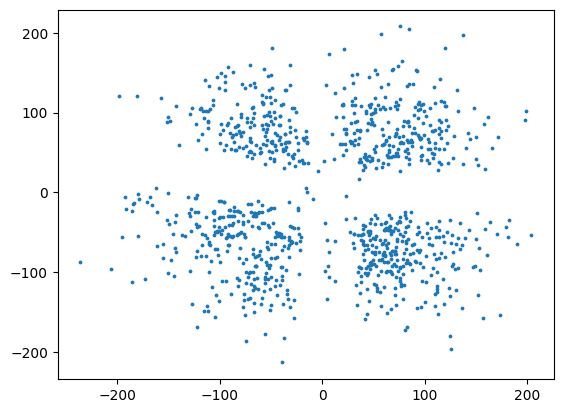

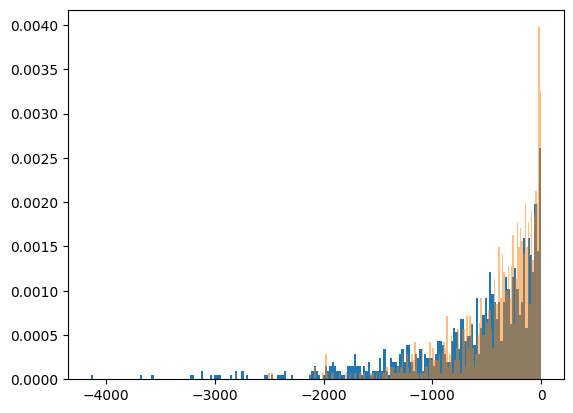

In [13]:
# Test Ito density Estimation
vp_reverse_sde = VPReverse_coupled(vp_scheduler)
samples_hightemp, _, logq = generate_samples_weighted(vp_reverse_sde, t_span=(1e-3, 1), num_integration_steps=num_int_steps,
                                                resampling_interval=None, inverse_temperature=1.0,
                                                samples=prior_samples, prior=vp_prior, compute_logq=True)
samples_energy = target(samples_hightemp)
samples_hightemp_unnorm_vp = target.unnormalize(samples_hightemp).detach().cpu().numpy()
plt.scatter(samples_hightemp_unnorm_vp[:, 0], samples_hightemp_unnorm_vp[:, 1], s=3)
plt.show()

plt.hist(samples_energy.detach().cpu(), bins=200, density=True);
plt.hist(- (logq[-1].detach().cpu() + log(target.data_normalization_factor**2)), bins=200, alpha=0.5, density=True);

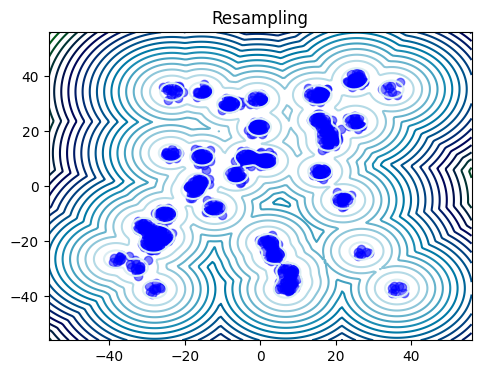

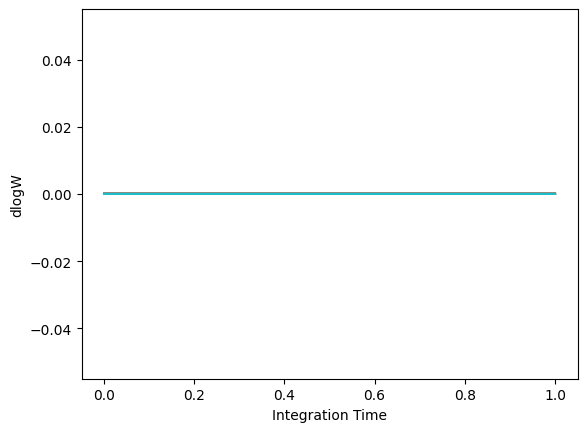

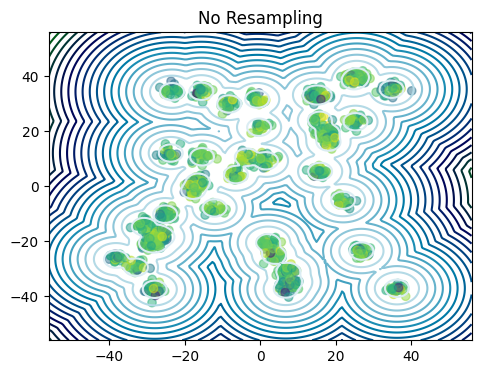

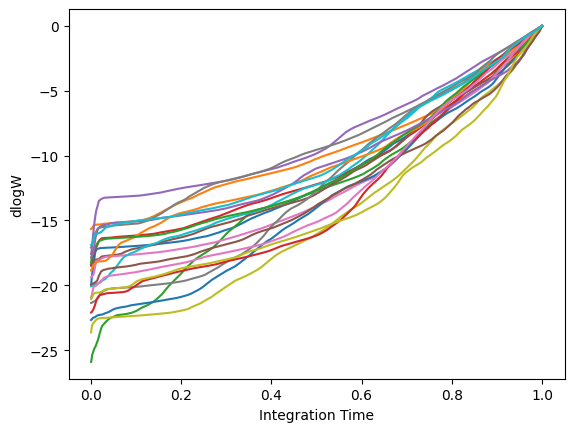

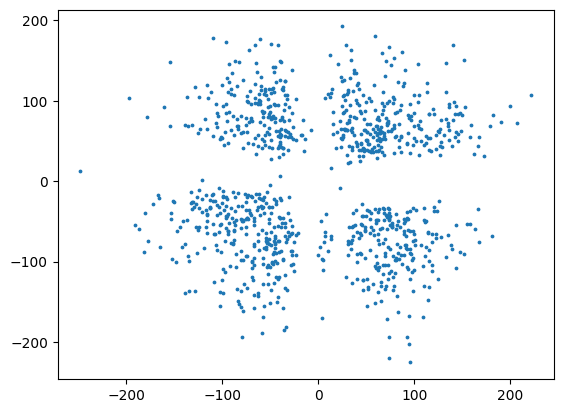

In [14]:
# Resampling
samples_resampled, log_weights = generate_samples_weighted(vp_reverse_sde, t_span=(0, 1), samples=annealed_prior_samples,
                                                 num_integration_steps=num_int_steps,
                                                 resampling_interval=1,
                                                 inverse_temperature=inverse_temperature)
target.get_dataset_fig(target.unnormalize(samples_resampled), T=inverse_temperature,
                       title="Resampling")
plt.show()

plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.ylabel("dlogW")
plt.show()


samples_not_resampled, log_weights = generate_samples_weighted(vp_reverse_sde, t_span=(0, 1), samples=annealed_prior_samples,
                                                               num_integration_steps=num_int_steps,
                                                               resampling_interval=num_int_steps+1,
                                                               inverse_temperature=inverse_temperature)
target.get_dataset_fig(target.unnormalize(samples_not_resampled), T=inverse_temperature, color=log_weights.cpu()[-1],
                       title="No Resampling")
plt.show()
plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.ylabel("dlogW")
plt.show()

# Generate samples at high temprature
samples_hightemp, _ = generate_samples_weighted(vp_reverse_sde, t_span=(0, 1), num_integration_steps=num_int_steps,
                                                resampling_interval=None, num_samples=num_samples, inverse_temperature=1.0,
                                                samples=prior_samples)
samples_energy = target(samples_hightemp)
# target.get_dataset_fig(target.unnormalize(samples_hightemp), T=1.0, title=f"Temperature {temperature}")
# plt.show()
samples_hightemp_unnorm = target.unnormalize(samples_hightemp).detach().cpu().numpy()
plt.scatter(samples_hightemp_unnorm[:, 0], samples_hightemp_unnorm[:, 1], s=3)
plt.show()

samples_not_resampled = samples_not_resampled.detach()
samples_resampled = samples_resampled.detach()

samples_resampled = target_temp1.unnormalize(samples_resampled)
samples_not_resampled = target_temp1.unnormalize(samples_not_resampled)


samples["vp resampled"] = samples_resampled
samples["vp not_resampled"] = samples_not_resampled


### Variance Exploding SDE

In [15]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, QuadraticNoiseSchedule
noise_schedule = GeometricNoiseSchedule(sigma_min=0.1, sigma_max=100 * sqrt(temperature))

#noise_schedule = QuadraticNoiseSchedule(beta=10)

In [28]:
num_int_steps = 2000 
num_samples = 1000

ve_reverse_sde = VEReverse_coupled(noise_schedule)

prior = Prior(2, device=device, scale = noise_schedule.h(1) ** 0.5)
annealed_prior = Prior(2, device=device, scale = (noise_schedule.h(1) / inverse_temperature) ** 0.5)


prior_samples = prior.sample(num_samples)
annealed_prior_samples = annealed_prior.sample(num_samples)

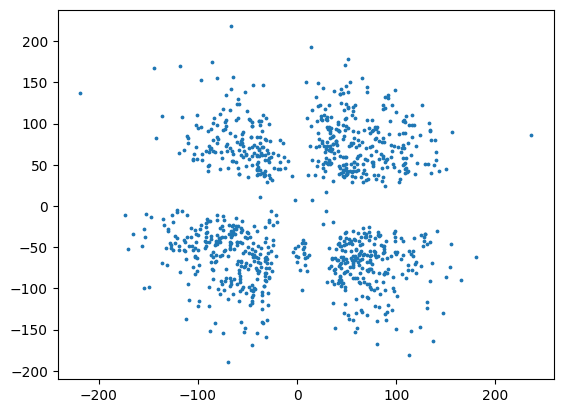

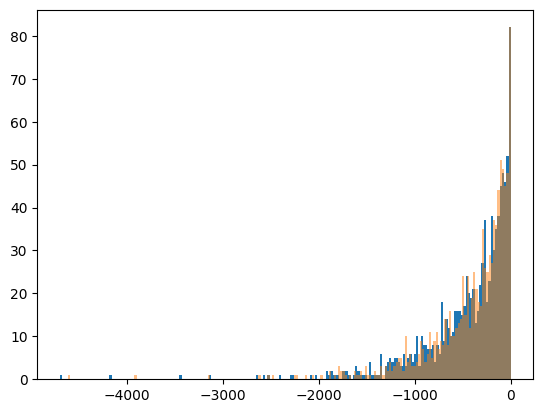

In [17]:
# Test Ito density Estimation
ve_reverse_sde = VEReverse_coupled(noise_schedule)
samples_hightemp, _, logq = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=num_int_steps,
                                                resampling_interval=None, num_samples=num_samples, inverse_temperature=1.0,
                                                samples=prior_samples, prior=prior, compute_logq=True)
samples_energy = target(samples_hightemp)
# target.get_dataset_fig(target.unnormalize(samples_hightemp), T=1.0, title=f"Temperature {temperature}")
samples_hightemp_unnorm = target.unnormalize(samples_hightemp).detach().cpu().numpy()
plt.scatter(samples_hightemp_unnorm[:, 0], samples_hightemp_unnorm[:, 1], s=3)
plt.show()

plt.hist(samples_energy.detach().cpu(), bins=200);
plt.hist(-(logq[-1].detach().cpu() + log(target.data_normalization_factor**2)), bins=200, alpha=0.5);

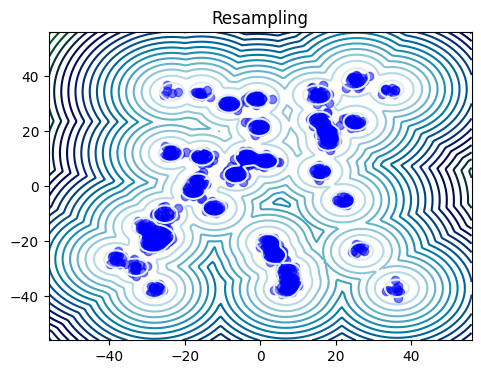

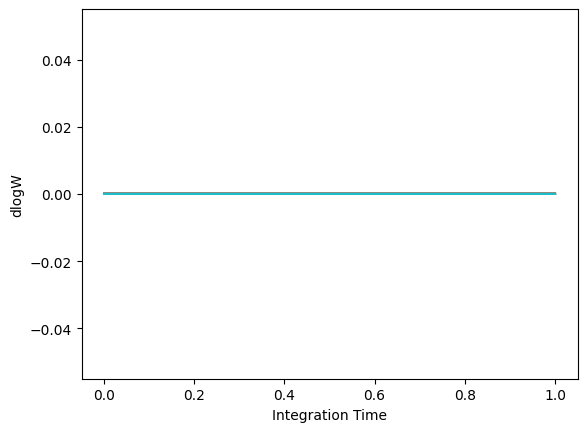

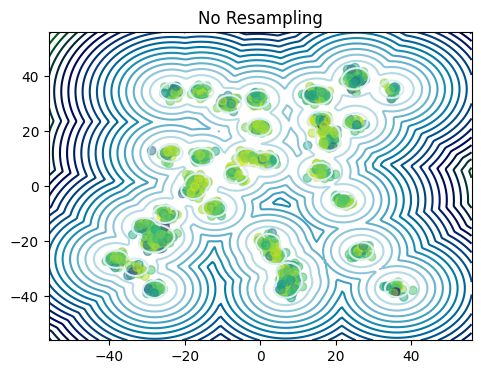

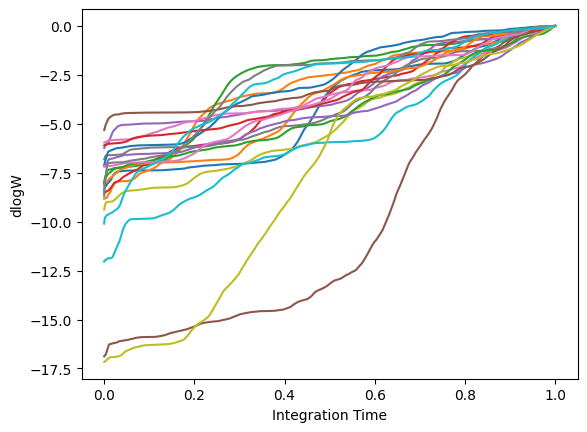

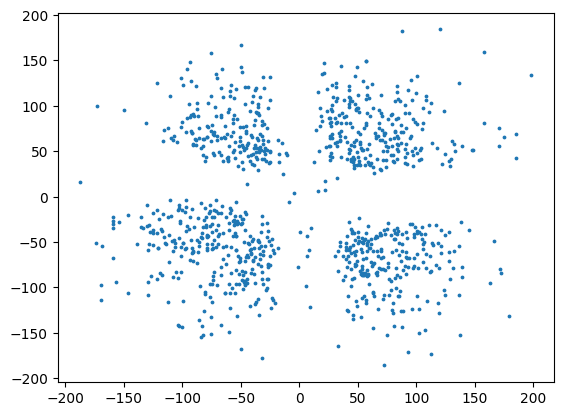

In [29]:
samples_resampled, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=annealed_prior_samples,
                                                 num_integration_steps=num_int_steps,
                                                 resampling_interval=1,
                                                 inverse_temperature=inverse_temperature)
target.get_dataset_fig(target.unnormalize(samples_resampled), T=inverse_temperature,
                       title="Resampling")
plt.show()
plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.ylabel("dlogW")
plt.show()


samples_not_resampled, log_weights = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), samples=annealed_prior_samples,
                                                               num_integration_steps=num_int_steps,
                                                               resampling_interval=num_int_steps+1,
                                                               inverse_temperature=inverse_temperature)
target.get_dataset_fig(target.unnormalize(samples_not_resampled), T=inverse_temperature, color=log_weights.cpu()[-1],
                       title="No Resampling")
plt.show()
plt.plot(torch.linspace(1, 0, num_int_steps), log_weights.cpu().detach().numpy()[:, :20])
plt.xlabel("Integration Time")
plt.ylabel("dlogW")
plt.show()

# Generate samples at high temprature
samples_hightemp, _ = generate_samples_weighted(ve_reverse_sde, t_span=(0, 1), num_integration_steps=num_int_steps,
                                                resampling_interval=None, num_samples=num_samples, inverse_temperature=1.0,
                                                samples=prior_samples)
samples_energy = target(samples_hightemp)
# target.get_dataset_fig(target.unnormalize(samples_hightemp), T=1.0, title=f"Temperature {temperature}")
samples_hightemp_unnorm = target.unnormalize(samples_hightemp).detach().cpu().numpy()
plt.scatter(samples_hightemp_unnorm[:, 0], samples_hightemp_unnorm[:, 1], s=3)
plt.show()


samples_resampled = samples_resampled.detach()
samples_not_resampled = samples_not_resampled.detach()

samples_resampled = target_temp1.unnormalize(samples_resampled)
samples_not_resampled = target_temp1.unnormalize(samples_not_resampled)

samples["ve resampled"] = samples_resampled
samples["ve not_resampled"] = samples_not_resampled


In [19]:
# plt.scatter(torch.linspace(1, 0, num_int_steps), log_weights.std(-1).cpu())
# plt.xlabel("Integration Time")
# plt.ylabel("Standard Deviation of dlogW")

### Metrics

In [30]:
from src.models.components.distribution_distances import eot
from src.models.components.mmd import linear_mmd2, mix_rbf_mmd2, poly_mmd2
from src.models.components.optimal_transport import wasserstein
import ot as pot

def compute_sample_based_metrics(a, b, a_energy, b_energy):
    w1 = wasserstein(a.double(), b.double(), power=1)
    w2 = wasserstein(a.double(), b.double(), power=2)
    mmd_rbf = mix_rbf_mmd2(a, b, sigma_list=10 ** np.linspace(-2, 0, 10)).item()

    H_b, x_b, y_b = np.histogram2d(b[:, 0].cpu().numpy(), b[:, 1].cpu().numpy(), bins=200)
    H_a, x_a, y_a = np.histogram2d(a[:, 0].cpu().numpy(), a[:, 1].cpu().numpy(), bins=(x_b, y_b))
    total_var = 0.5 * np.abs(H_a/H_a.sum() - H_b/H_b.sum()).sum()

    energy_w2 = pot.emd2_1d(
    a_energy,
    b_energy,
    ).detach().cpu().item()
    return w1, w2, mmd_rbf, total_var, energy_w2

In [31]:
# test_samples = target_temp1.sample_test_set(1000)
# samples_resampled = samples_resampled.detach()
# samples_not_resampled = samples_not_resampled.detach()

# samples_resampled = target_temp1.unnormalize(samples_resampled)
# samples_not_resampled = target_temp1.unnormalize(samples_not_resampled)

# plt.scatter(samples_resampled[:, 0].cpu(), samples_resampled[:, 1].cpu(), s=3)
# plt.scatter(test_samples[:, 0].cpu(), test_samples[:, 1].cpu(), s=3)
# plt.scatter(samples_not_resampled[:, 0].cpu(), samples_not_resampled[:, 1].cpu(), s=3)
# plt.show()

In [32]:
# samples["resampled"] = samples_resampled
# samples["not_resampled"] = samples_not_resampled
# samples["Test"] = test_samples.detach()


for key in samples.keys():
    energies[key] = target_temp1(samples[key]).detach()

In [33]:
data_df = []
metrics= ["W1", "W2", "MMD", "Total Var", "Energy W2"]
for key in samples.keys():
    if key == "Test":
        continue
    
    data_df.append([key, *compute_sample_based_metrics(samples[key], samples["Test"],
                                                       energies[key], energies["Test"])])

In [34]:
import pandas as pd
df = pd.DataFrame(data_df)
df.columns = ["Method"] + metrics

In [35]:
df

,Method,W1,W2,MMD,Total Var,Energy W2
0,vp resampled,4.390129,6.962083,0.021334,0.832000,0.128076
1,vp not_resampled,2.109850,3.821671,0.019982,0.833916,0.013907
2,ve resampled,4.183254,6.772973,0.021772,0.831981,0.069846
3,ve not_resampled,2.533856,4.401113,0.019667,0.807891,0.008545
